# Glacier area - streamflow scaling in Alberta: EOSC 453 Discussion

___


### Goal

Investigate how the loss of glaciers will impact August streamflow at downstream locations.

### General Approach:

We will:

1) **Investigate**: Visually compare streamflow timeseries between glacier-fed and non-glacier-fed rivers across Alberta.  
2) **Characterize**: Determine key variables at each stream gauge to be mean August flow ($\mu$) and the standard deviation of August flow year-to-year ($\sigma$).  
3) **Model**: Use empirical models to predict glacier-fed $\mu$ and $\sigma$ from glacierization, and non-glacier-fed $\mu$ and $\sigma$ from local climate variables and local streamflow characteristics.  
4) **Explore**: The difference between these two model predictions is an estimate for how much, and in what ways, a glacier-fed river may change under a total loss of glaciers.  
5) **Ask**: Which communities will experience a substantial change to their water supply?  What other questions can we ask using this investigative framework?

In [1]:
#import required libraries

# %matplotlib inline

#plotting libraries
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import axes3d 

#numerical/data libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.linear_model import LinearRegression

#visualization libraries
from IPython.display import HTML, display
import ipywidgets

#set random seed for reproducability
ss = 00
np.random.seed(ss)

In [2]:
#define functions we'll use
def make_gaussian(mu, sigma):
    
    # This function generates a gaussian distribution from a mean (mu) and standard deviation (sigma)
    # mu = mean
    # sigma = std deviation
    #gauss = gaussian distribution
    #x = array of x-values corresponding the values in gaussian; units same as mu and sigma
    
    x = np.linspace(mu-4*sigma,mu+4*sigma,100)
    gauss = [(1 / sigma / np.sqrt(2*np.pi)) * np.exp(-0.5 * ((xx - mu)/sigma)**2) for xx in x]
    
    return gauss, x

# def plot_prov_ax(prov, ax):

#     """
#     plot borders of a province on a given axis
    
#     prov: string; 'AB', 'BC', or 'AB_BC'
#     ax: axis on which to plot the provincial borders
#     """
    
#     if prov == 'AB_BC':
#       provs = ['AB', 'BC']
#       for prov in provs:
#         if prov == 'AB':
#           provIndex=0
#         elif prov == 'BC':
#           provIndex = 11
#         provshapes_filename = '/Users/samanderson/PROVINCE.SHP'
#         provshapes = gpd.read_file(provshapes_filename)
#         provPoly = provshapes['geometry'][provIndex]

#         if len(np.shape(provPoly)) == 0: #if only one polygon to plot

#           lonBorder,latBorder = provPoly.exterior.coords.xy 
#           ax.plot(lonBorder,latBorder,'k')

#         else: #if multiply polygons in shape to plot

#           for ind in range(len(provPoly)):

#             lonBorder_segment,latBorder_segment = provPoly[ind].exterior.coords.xy 
#             ax.plot(lonBorder_segment,latBorder_segment,'k')

#     else:
#       if prov == 'AB':
#         provIndex=0
#       elif prov == 'BC':
#         provIndex = 11
#       provshapes_filename = '/Users/samanderson/PROVINCE.SHP'
#       provshapes = gpd.read_file(provshapes_filename)
#       provPoly = provshapes['geometry'][provIndex]

#       if len(np.shape(provPoly)) == 0: #if only one polygon to plot

#         lonBorder,latBorder = provPoly.exterior.coords.xy 
#         ax.plot(lonBorder,latBorder,'k')

#       else: #if multiply polygons in shape to plot

#         for ind in range(len(provPoly)):

#           lonBorder_segment,latBorder_segment = provPoly[ind].exterior.coords.xy 
#           ax.plot(lonBorder_segment,latBorder_segment,'k')

___

### Investigate

Start by loading streamflow data and comparing streamflow timeseries of a glacier-fed river vs a non-glacier-fed river.  Let's see how two stream gauge stations compare over all days in all years, and then just in each August.

In [3]:
#load flow data -- dictionary saved in a .pickle file
flowDataPath = '/Users/samanderson/repos/CNN_LSTM_ERA_original/'
flowPickle = 'AB_flowvars_1987_2010_missing_4_4_1.pickle' #filenames of pickle files which contain AB streamflow data
pickle_in = open(flowDataPath + flowPickle, 'rb')
flowDict = pickle.load(pickle_in)

#list the keys to the dictionary to see what data is available
flowDict.keys()

dict_keys(['stationID', 'stationName', 'stationLat', 'stationLon', 'stationDrainageArea', 'all_flowseason', 'all_flowseason_NF', 'all_flowseason_norm', 'all_flowseason_norm_NF', 'all_flow', 'all_flow_NF', 'windowDates', 'windowYears', 'windowMonths', 'windowDays', 'params'])

In [4]:
#we want: flow, station latitude, and station longitude
F = np.squeeze(np.asarray(flowDict['all_flow_NF'])) #streamflow [m^3/s] at each station from 1987 - 2010, with missing data filled by seasonal values (NF = 'nans filled')
lon = flowDict['stationLon'] #longitude of stream gauge stations
lat = flowDict['stationLat'] #latitude of stream gauge stations

In order to compare two stream gauges to each other, we will:  
1) Smooth with 30-day running mean  
2) Normalize by each stations mean flow and variance (want: zero mean and unity variance)  
3) Extract only august (this is when glacier runoff is most prominent)

In [5]:
#initialize
Nyears = 24
Fsmooth_all = np.zeros_like(F)
Faug_all = np.zeros((len(lon), 31, Nyears)) #station x day of august x year
Faug_all_norm = np.zeros((len(lon), 31, Nyears)) #station x day of august x year
F_all_norm = np.zeros((len(lon), 365, Nyears)) #station x day of year x year
F_station_mean = np.zeros(len(lon))
F_station_std = np.zeros(len(lon))

#restructure: station x 1 year/month of data x years
aug1 = 210
aug31 = 241
for station in range(len(F)):
    
    #first, smooth whole series
    Fsmooth = pd.Series(F[station]).rolling(window = 30, min_periods = 1).mean()
    Fsmooth_all[station] = Fsmooth
    
    #calc mean/stdev for this station over the whole time period
    F_station_mean[station] = np.mean(Fsmooth_all[station])
    F_station_std[station] = np.std(Fsmooth_all[station])
    
    #restructure each year
    for year in range(Nyears):
        start = year*365
#         Fmean = np.mean(Fsmooth_all[station, start : start + 365])
#         Fstd = np.std(Fsmooth_all[station, start: start + 365])
        Faug = Fsmooth_all[station, start + aug1 : start + aug31]
        Faug_all[station,:,year] = Fsmooth_all[station, start + aug1 : start + aug31]
        Faug_all_norm[station,:,year] = (Faug - F_station_mean[station]) / F_station_std[station]
        F_all_norm[station,:,year] = (Fsmooth_all[station, start : start + 365] - F_station_mean[station]) / F_station_std[station]
        
#mean/stdev of normalized august flow for each station        
Faug_all_norm_mean = np.mean(np.mean(Faug_all_norm, axis = 1), axis = -1)
Faug_all_norm_std = np.std(np.mean(Faug_all_norm, axis = 1), axis = -1)

In [11]:
colors11 = [(np.array([144, 76, 119])/256), (1,1,1)] # colour of non-glacier-fed plot
cm1 = LinearSegmentedColormap.from_list('test', colors11, N=Nyears)

colors22 = [(np.array([219, 168, 172])/256), (1,1,1)] # colour of glacier-fed plot
cm2 = LinearSegmentedColormap.from_list('test', colors22, N=Nyears)

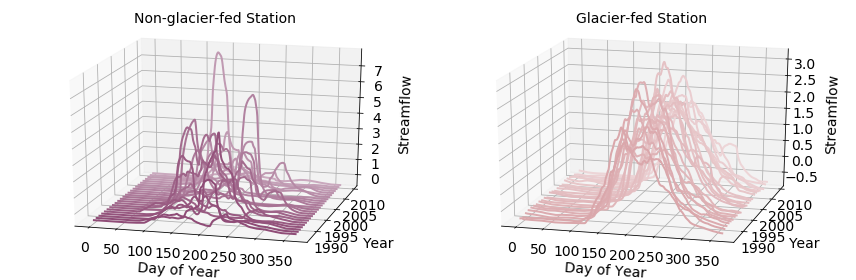

In [12]:
#visualize: smoothed streamflow series

saveIt = 0

fig = plt.figure(figsize = (12,4))

colours1 = cm1(np.linspace(0,0.5,Nyears))
colours2 = cm2(np.linspace(0,0.5,Nyears))

ax00 = fig.add_subplot(121, projection='3d')
ax01 = fig.add_subplot(122, projection='3d')

fs = 14
el = 20
az = 285

for year in range(Nyears-1,-1,-1):

    ys = (1987+year) * np.ones(365)
    xs = np.arange(365)
    
    station = 103
    zs = F_all_norm[station,:,year]
    ax00.plot(xs, ys, zs, c = colours1[year], linewidth = 2)
    
    station = 88
    zs = F_all_norm[station,:,year]
    ax01.plot(xs, ys, zs, c = colours2[year], linewidth = 2)
    
ax00.set_xlabel('Day of Year', fontsize = fs, labelpad = 10)
ax00.set_ylabel('Year', fontsize = fs, labelpad = 15)
ax00.set_zlabel('Streamflow', fontsize = fs, labelpad = 10)
ax00.set_title('Non-glacier-fed Station', fontsize = fs)
ax00.tick_params(labelsize = fs)
ax00.view_init(el, az)

ax01.set_xlabel('Day of Year', fontsize = fs, labelpad = 10)
ax01.set_ylabel('Year', fontsize = fs, labelpad = 15)
ax01.set_zlabel('Streamflow', fontsize = fs, labelpad = 10)
ax01.set_title('Glacier-fed Station', fontsize = fs)
ax01.tick_params(labelsize = fs)
ax01.view_init(el, az)

plt.tight_layout()

if saveIt: 
    plt.savefig('all_years_two_stations.png', bbox_inches = 'tight', dpi = 200)

plt.show()

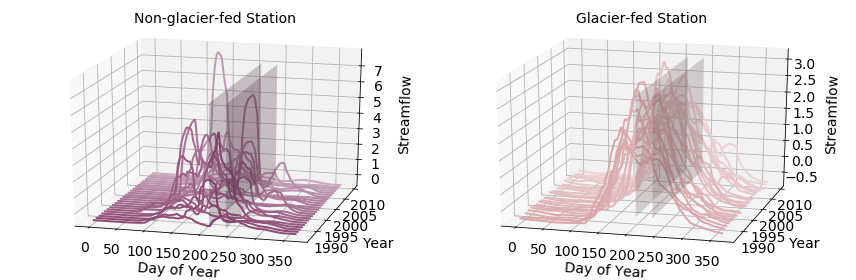

In [13]:
#visualize: smoothed streamflow series w/ planes bookending August

saveIt = 0

fig = plt.figure(figsize = (12,4))

colours1 = cm1(np.linspace(0,0.5,Nyears))
colours2 = cm2(np.linspace(0,0.5,Nyears))

ax00 = fig.add_subplot(121, projection='3d')
ax01 = fig.add_subplot(122, projection='3d')

fs = 14

for year in range(Nyears-1,-1,-1):

    ys = (1987+year) * np.ones(365)
    xs = np.arange(365)
    
    station = 103
    zs = F_all_norm[station,:,year]
    ax00.plot(xs, ys, zs, c = colours1[year], linewidth = 2)
    
    station = 88
    zs = F_all_norm[station,:,year]
    ax01.plot(xs, ys, zs, c = colours2[year], linewidth = 2)
    
yy, zz = np.meshgrid([1987,2010], [-0.5,7])
xx1 = 210*np.ones_like(yy)
xx2 = 240*np.ones_like(yy)
ax00.plot_surface(xx1,yy,zz, color = colors1[0],alpha = 0.25)
ax00.plot_surface(xx2,yy,zz, color = colors1[0],alpha = 0.25)

yy, zz = np.meshgrid([1987,2010], [-0.5,3])
xx1 = 210*np.ones_like(yy)
xx2 = 240*np.ones_like(yy)
ax01.plot_surface(xx1,yy,zz, color = colors2[0],alpha = 0.25)
ax01.plot_surface(xx2,yy,zz, color = colors2[0],alpha = 0.25)

ax00.set_xlabel('Day of Year', fontsize = fs, labelpad = 10)
ax00.set_ylabel('Year', fontsize = fs, labelpad = 15)
ax00.set_zlabel('Streamflow', fontsize = fs, labelpad = 10)
ax00.set_title('Non-glacier-fed Station', fontsize = fs)
ax00.tick_params(labelsize = fs)
ax00.view_init(el,az)

ax01.set_xlabel('Day of Year', fontsize = fs, labelpad = 10)
ax01.set_ylabel('Year', fontsize = fs, labelpad = 15)
ax01.set_zlabel('Streamflow', fontsize = fs, labelpad = 10)
ax01.set_title('Glacier-fed Station', fontsize = fs)
ax01.tick_params(labelsize = fs)
ax01.view_init(el, az)

plt.tight_layout()

if saveIt: 
    plt.savefig('all_years_two_stations_planes.png', bbox_inches = 'tight', dpi = 200)

plt.show()

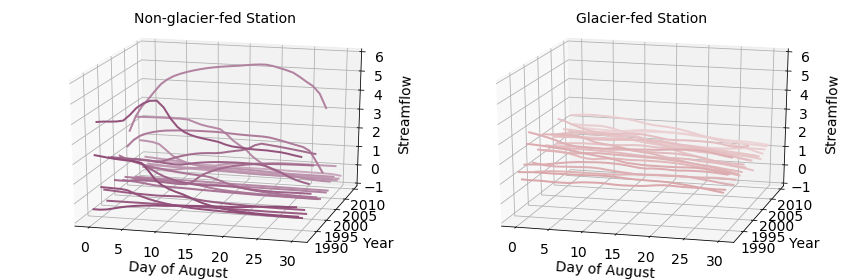

In [14]:
#Here, we'll plot all years of August on the same z-scale for comparison b/w the two cases

saveIt = 0

fig = plt.figure(figsize = (12,4))

colours1 = cm1(np.linspace(0,0.5,Nyears))
colours2 = cm2(np.linspace(0,0.5,Nyears))

ax00 = fig.add_subplot(121, projection='3d')
ax01 = fig.add_subplot(122, projection='3d')

fs = 14
el = 20
az = 285

for year in range(Nyears-1,-1,-1):

    xs = np.arange(31)
    ys = (1987+year) * np.ones(31)
    
    station = 103
    zs = Faug_all_norm[station,:,year]
    ax00.plot(xs, ys, zs, c = colours1[year], linewidth = 2)
    
    station = 88
    zs = Faug_all_norm[station,:,year]
    ax01.plot(xs, ys, zs, c = colours2[year], linewidth = 2)

ax00.set_zlim((-1,6))
ax00.set_xlabel('Day of August', fontsize = fs, labelpad = 10)
ax00.set_ylabel('Year', fontsize = fs, labelpad = 15)
ax00.set_zlabel('Streamflow', fontsize = fs, labelpad = 10)
ax00.set_title('Non-glacier-fed Station', fontsize = fs)
ax00.tick_params(labelsize = fs)
ax00.view_init(el,az)

ax01.set_zlim((-1,6))
ax01.set_xlabel('Day of August', fontsize = fs, labelpad = 10)
ax01.set_ylabel('Year', fontsize = fs, labelpad = 15)
ax01.set_zlabel('Streamflow', fontsize = fs, labelpad = 10)
ax01.set_title('Glacier-fed Station', fontsize = fs)
ax01.tick_params(labelsize = fs)
ax01.view_init(el,az)

plt.tight_layout()

if saveIt: 
    plt.savefig('all_years_two_stations_august.png', bbox_inches = 'tight', dpi = 200)

plt.show()

___

### Characterize

Now, using each stream gauge stations' set of August streamflow timeseries, we will characterize each August as a mean value and a slope calculated from linear regression.

**Justification**: The decision to characterize using mean/slope is a choice that comes out of performing principal component analysis (PCA) on all August timeseries for all stations.  The first mode describes >80% of the variance in the dataset, while the second mode describes ~10% of the variance.  The principal components (PCs) of the first mode strongly correlate with mean August flow (unitless), while the PCs of the second mode strongly correlate with the slope ($day^{-1}$).  Here, we will skip the PCA portion and just take advantage of the results.  For more details, see Anderson and Radic (2020).

**Key Takeaway**: Each year at each station can be described by two values -- mean August flow and the linear slope of August flow.  These values capture a majority of the variance across the whole dataset.   

In [15]:
#Here, we'll skip the PCA portion for consiseness of the lecture and just take advantage of the results

Faug_mean_series = np.mean(Faug_all_norm, axis = 1) #mean of each year, for each station
Faug_slope_series = np.zeros_like(Faug_mean_series) #slope of each year, for each station

#do linear regression to calculate the slope
Faug_norm_linear = np.zeros_like(Faug_all_norm)
for station in range(len(lon)): #for each station
    for year in range(Nyears): #and each year
        xx = np.arange(31).reshape(-1,1)
        yy = Faug_all_norm[station,:,year].reshape(-1,1)
        model = LinearRegression().fit(xx, yy)
        slope = model.coef_
        Faug_slope_series[station,year] = slope
        Faug_norm_linear[station,:,year] = np.squeeze(model.predict(xx))
        
Faug_mean = np.mean(Faug_mean_series, axis = -1)
Faug_std = np.std(Faug_mean_series, axis = -1)

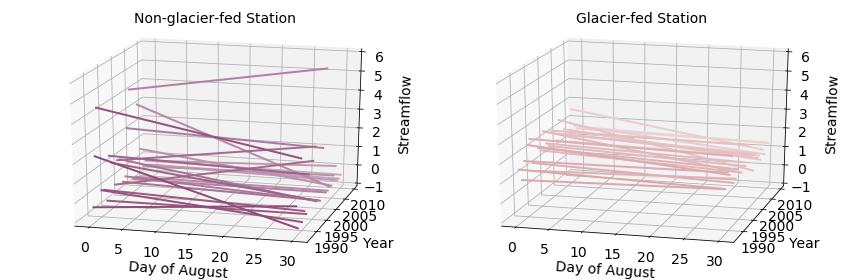

In [16]:
#visualize linearized versions of August flow

saveIt = 0

fig = plt.figure(figsize = (12,4))

colours1 = cm1(np.linspace(0,0.5,Nyears))
colours2 = cm2(np.linspace(0,0.5,Nyears))

ax00 = fig.add_subplot(121, projection='3d')
ax01 = fig.add_subplot(122, projection='3d')

fs = 14
el = 20
az = 285

for year in range(Nyears-1,-1,-1):

    ys = (1987+year) * np.ones(31)
    xs = np.arange(31)
    
    station = 103
    zs = Faug_norm_linear[station,:,year]
    ax00.plot(xs, ys, zs, c = colours1[year], linewidth = 2)
    
    station = 88
    zs = Faug_norm_linear[station,:,year]
    ax01.plot(xs, ys, zs, c = colours2[year], linewidth = 2)

ax00.set_zlim((-1,6))
ax00.set_xlabel('Day of August', fontsize = fs, labelpad = 10)
ax00.set_ylabel('Year', fontsize = fs, labelpad = 15)
ax00.set_zlabel('Streamflow', fontsize = fs, labelpad = 10)
ax00.set_title('Non-glacier-fed Station', fontsize = fs)
ax00.tick_params(labelsize = fs)
ax00.view_init(el,az)

ax01.set_zlim((-1,6))
ax01.set_xlabel('Day of August', fontsize = fs, labelpad = 10)
ax01.set_ylabel('Year', fontsize = fs, labelpad = 15)
ax01.set_zlabel('Streamflow', fontsize = fs, labelpad = 10)
ax01.set_title('Glacier-fed Station', fontsize = fs)
ax01.tick_params(labelsize = fs)
ax01.view_init(el,az)
    
plt.tight_layout()

if saveIt: 
    plt.savefig('all_years_two_stations_august_linear.png', bbox_inches = 'tight', dpi = 200)

plt.show()

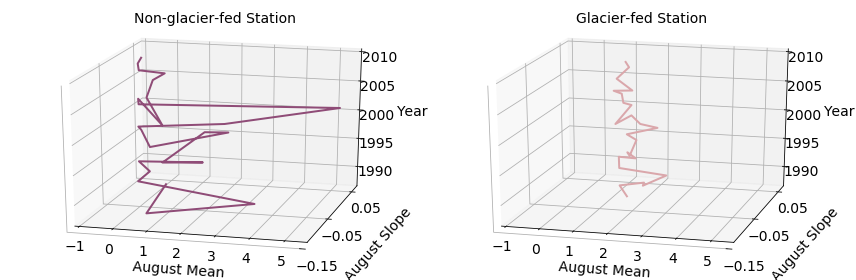

In [17]:
#visualize mean/slope time series

saveIt = 0

fig = plt.figure(figsize = (12,4))

colours1 = cm1(0)
colours2 = cm2(0)

ax00 = fig.add_subplot(121, projection='3d')
ax01 = fig.add_subplot(122, projection='3d')

fs = 14
el = 20
az = 285
    
zs = np.arange(1987,2011)

station = 103
xs = Faug_mean_series[station,:]
ys = Faug_slope_series[station,:]
ax00.plot(xs, ys, zs, color = colours1, linewidth = 2)


station = 88
xs = Faug_mean_series[station,:]
ys = Faug_slope_series[station,:]
ax01.plot(xs, ys, zs, color = colours2, linewidth = 2)

ax00.set_xlim((-1,5.5))
ax00.set_ylim((-0.125,0.07))
ax00.set_zlim((1987,2010))
ax00.set_xlabel('August Mean', fontsize = fs, labelpad = 10)
ax00.set_ylabel('August Slope', fontsize = fs, labelpad = 15)
ax00.set_zlabel('Year', fontsize = fs, labelpad = 15)
ax00.set_title('Non-glacier-fed Station', fontsize = fs)
ax00.tick_params(labelsize = fs)
ax00.set_yticks(ax00.get_yticks()[::2])
ax00.view_init(el,az)

ax01.set_xlim((-1,5.5))
ax01.set_ylim((-0.125,0.07))
ax01.set_zlim((1987,2010))
ax01.set_xlabel('August Mean', fontsize = fs, labelpad = 10)
ax01.set_ylabel('August Slope', fontsize = fs, labelpad = 15)
ax01.set_zlabel('Year', fontsize = fs, labelpad = 15)
ax01.set_title('Glacier-fed Station', fontsize = fs)
ax01.tick_params(labelsize = fs)
ax01.set_yticks(ax01.get_yticks()[::2])
ax01.view_init(el,az)
    
plt.tight_layout()

if saveIt: 
    plt.savefig('all_years_two_stations_august_trajectory.png', bbox_inches = 'tight', dpi = 200)
    
plt.show()

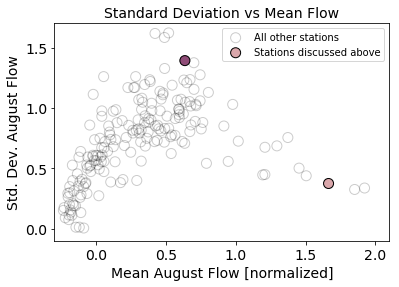

In [18]:
#visualize each station in the space of std. deviation of August flow vs mean August flow

saveIt = 0

stations = [88, 103]
xlim = [-0.3, 2.1]
ylim = [-0.1, 1.7]
c = [colours2, colours1]

fig, ax = plt.subplots()

ax.scatter(Faug_mean, Faug_std, s = 100, edgecolor = 'k', facecolor = [], alpha = 0.2, label = 'All other stations')
ax.scatter(Faug_mean[stations], Faug_std[stations], c = c, s = 100, edgecolor = 'k', label = 'Stations discussed above')
ax.legend()
ax.set_xlabel('Mean August Flow [normalized]', fontsize = fs)
ax.set_ylabel('Std. Dev. August Flow', fontsize = fs)
ax.set_title('Standard Deviation vs Mean Flow', fontsize = fs)
ax.tick_params(labelsize = fs)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

if saveIt: 
    plt.savefig('std_vs_mean_all_stations.png', bbox_inches = 'tight', dpi = 200)

plt.show()

**Summary so far**:  We have compressed the original dataset to the time period of interest, and extracted the two features of interest.

**Key finding**:  The single glacier-fed station has high mean flow with low variability as compared to the single non-glacier-fed station.

**Next questions**: What are the characteristic $\mu$ and $\sigma$ for all other stations?  Which stations have a similar timeseries of mean August flow and August flow slope?  Do all glacier-fed stations behave similarly as the one shown above?  If one station has more glaciers than another, what is the effect?

**General approach**:  We will cluster the stations according to similarity in the space of mean August flow, August flow slope, and time.  We will then see what the characteristics of each cluster are and where they occur in space.

In [19]:
#to cluster in the space of two variables, we need to normalize each variable (zero-mean, unity variance)

#calculate the mean/standard deviation of the August mean/slope across stations
mean_mean = np.mean(Faug_mean_series)
mean_std = np.std(Faug_mean_series)
slope_mean = np.mean(Faug_slope_series)
slope_std = np.std(Faug_slope_series)

#subtract mean, divide by standard deviation
mm = (Faug_mean_series - mean_mean) / mean_std
ss = (Faug_slope_series - slope_mean) / slope_std

#cluster input has N_observations = N_stations, N_dimensions = 2 (mean, std dev)
cluster_input = np.hstack((mm, ss))

In [20]:
#cluster using k-means; choice of 6 clusters comes out of external analysis + to be consistent with Anderson + Radic (2020)

n_clusters = 6
kmeans = KMeans(n_clusters = n_clusters).fit(cluster_input)
labels = kmeans.labels_

In [21]:
#find mean pattern of each cluster
cluster_pattern = np.empty((n_clusters,np.shape(cluster_input)[1]))
for cluster_num in range(n_clusters):
    inds = np.argwhere(labels==cluster_num)
    cluster_pattern[cluster_num,:] = np.mean(cluster_input[inds,:],axis=0)
    
cluster_obs = np.empty((np.shape(cluster_input)))
for ind in range(len(cluster_input)):
    cluster_obs[ind] = cluster_pattern[labels[ind]]

In [24]:
#colours: chosen from coolors.co -- check out the website for great colour schemes

# rgbs = np.asarray([
#     [36, 123, 160],
#     [202, 186, 200],
#     [178, 221, 247],
#     [127, 182, 133],
#     [255, 51, 105],
#     [68, 36, 34]
# ])

rgbs = np.asarray([
    [40, 150, 90],
    [124, 80, 121],
    [9, 145, 195],
    [255, 159, 178],
    [226, 207, 234],
    [247, 197, 159]
])

rgbs_1 = rgbs / 256

cStations = np.zeros((len(lon), 3))
for station in range(len(lon)):
    cStations[station,:] = rgbs_1[labels[station],:]

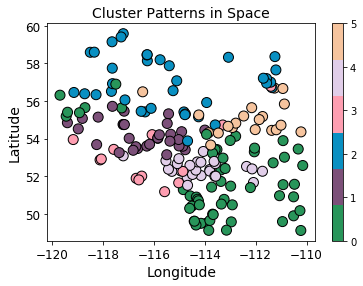

In [26]:
#visualize the clusters of stream gauges in space

saveIt = 0

fig, ax = plt.subplots()

sc = ax.scatter(lon, lat, c = cStations, s = 100, edgecolor = 'k', zOrder = 3)
#plot_prov_ax(prov = 'AB', ax = ax)
ax.set_xlabel('Longitude', fontsize = fs)
ax.set_ylabel('Latitude', fontsize = fs)
ax.set_title('Cluster Patterns in Space', fontsize = fs)
ax.tick_params(labelsize = fs - 2)

#colorbar
my_cmap = colors.ListedColormap(rgbs_1)
norm = colors.Normalize(vmin = 0, vmax = 5)
mappable = cm.ScalarMappable(cmap = my_cmap, norm = norm)
mappable.set_array([])
plt.colorbar(mappable)

if saveIt: 
    plt.savefig('cluster_patterns_space.png', bbox_inches = 'tight', dpi = 200)

plt.show()

**Notice**: Stream gauge stations which are nearby each other (e.g. north of 56$^{\circ}$) tend to cluster together (i.e. have similar streamflow characteristics).  

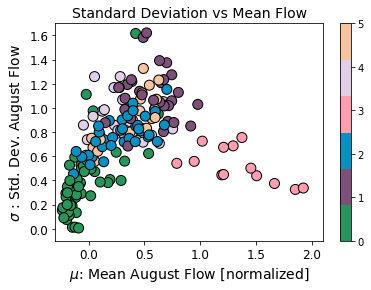

In [27]:
#visualize the clusters in the space of sigma vs mu

saveIt = 0

fig, ax = plt.subplots()

ax.scatter(Faug_mean, Faug_std, c = cStations, s = 100, edgecolor = 'k')

ax.set_xlabel('$\mu$: Mean August Flow [normalized]', fontsize = fs)
ax.set_ylabel('$\sigma$ : Std. Dev. August Flow', fontsize = fs)
ax.set_title('Standard Deviation vs Mean Flow', fontsize = fs)
ax.tick_params(labelsize = fs-2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

#colorbar
my_cmap = colors.ListedColormap(rgbs_1)
norm = colors.Normalize(vmin = 0, vmax = 5)
mappable = cm.ScalarMappable(cmap = my_cmap, norm = norm)
mappable.set_array([])
plt.colorbar(mappable, ax = ax)

if saveIt:
    plt.savefig('sigma_vs_mu_clustered.png', bbox_inches = 'tight', dpi = 200)

plt.show()

**Key findings from the above analysis**:

- Non-glacier-fed clusters, where an increase in mean is accompanied by an increase in variability (i.e. when August flow is high on average, it is not consistently high each year; when August flow is low on average, it is low each year)
- Glacier-fed cluster, where an increase in mean can be achieved without the cost of an increase in variability (i.e. when August flow is high on average, it is consistently high each year)

___

### Model

A key element of Anderson and Radic (2020) was developing linear models for $\mu$ and $\sigma$ for the glacier-fed and non-glacier-fed cases.  Details can be found in the paper; here the results will be summarized in the context of the above analysis.

There is a non-linear relationship between the percentage glacierization $G$ (glacierized area divided by the basin area, expressed as a value between 0 and 1), and $\mu$.  This relationship is most pronounced when $G>0.01$ (or 1% glacierization).  This means that for sufficiently glaciated rivers, to estimate the $\mu$, all we need to know is $G$, which can be calculated at any point along a river.

This finding is demonstrated in the following figure, used from Anderson and Radic (2020).  **Note**: $\overline{PC_1}$ approximately scales linearly with $\mu$.  Cluster 3 (the glacier-fed cluster) in the below figure approximately maps to Cluster 3 (the glacier-fed cluster) in the above analysis.

<img src='glacier_influence.png' width=350 >

For non-glacier-fed rivers, we find that both $PC_1$ and $\sigma_{PC1}$ can be estimated by metrics derived from local climate and conditions:

$$
\overline {PC_1} = -0.34 - 0.60\times T_{year} + 0.96\times P_{JJA} + 0.87\times T_{JJA} + 0.44\times E_{JJA} + 0.41\times log_{10}\big(\frac{Q_{min}}{Q_{max}}\big)
$$

$$
\sigma_{PC_1} = -2.49 + 0.52\times P_{JJA} + 0.26\times E_{JJA} - 0.68\times h + 0.42\times log_{10}\big(\frac{Q_{min}}{Q_{max}}\big)
$$

Where:

- $T_{year}$ is the yearly average temperature [$^{\circ}C$]
- $T_{JJA}$ is the June-July-August average temperature [$^{\circ}C$]
- $P_{JJA}$ is the June-July-August total precipitation [$mm$]
- $E_{JJA}$ is the June-July-August average evaporation [$mm$]
- $Q_{min}$ is the minimum seasonal streamflow [$m^3 s^{-1}$]
- $Q_{max}$ is the maximum seasonal streamflow [$m^3 s^{-1}$]
- $h$ is the stream gauge elevation [$m$]

All predictor variables are noramlized to have zero mean and unity variance (dimensionless), but their original dimensions are shown above.

**Key takeaways**:

- August streamflow in glacier-fed rivers can be estimated by $G$.

- August streamflow in non-glacier-fed rivers can be estimated by $T_{year}$, $T_{JJA}$, $P_{JJA}$, $E_{JJA}$, $Q_{min}$, $Q_{max}$, and $h$.

**Question**:

How will August streamflow distributions change in time in a basin which transitions from sufficiently glaciated to not glaciated?

___

### Explore

We've identified two regimes of streamflow behaviour: one where glaciers control August streamflow, and one where climate/local characteristics control streamflow. But what happens as glaciers retreat?

Let's visualize how glacierization will change in time and walk through how this may play out.

**Assume:** 

- Glacier area is decreasing linearly with time, until all glacier area is gone.  

**Parameters:**

- $t_g$: Time for glaciers to entirely melt; i.e. $G(t = t_g) = 0$
- $G_0$: Initial glacierization area, as a fraction of basin area (between 0 and 1) 

**Equation:**

$
G(t) = \left\{
\begin{array}{ll}
    G_0(1 - \frac{t}{t_g}) & , t < t_g \\
    0 & , t\ge t_g \\
\end{array}
\right.
$

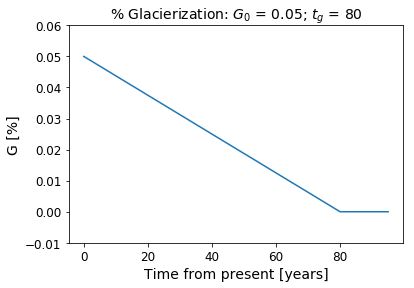

In [28]:
#define constants, G(t)
t_g = 80 #time in years for total loss of glaciers
t_f = 1.2 * t_g #final time in years
dt = 1 #time step
Ng = int(t_g / dt) #number of time steps for total loss of glaciers
Nf = int(t_f / dt) #number of total time steps
t = np.linspace(0, t_f-1, Nf) #time (years) 

G_0 = 0.05 #initial glacierization
G = G_0 * (1 - t/t_g) #G(t)
G[G<0] = 0 #set negative glacierization to 0 (e.g. G(t>t_g) = 0)

#visualize
fs = 14 #fontsize to use in figures
fig, ax = plt.subplots()
ax.plot(t, G)
ax.set_xlabel('Time from present [years]', fontsize = fs)
ax.set_ylabel('G [%]', fontsize = fs)
ax.set_title('% Glacierization: $G_0$ = ' + str(G_0) + '; $t_g$ = ' + str(t_g), fontsize = fs)
ax.set_ylim((np.min(G) - 0.01, np.max(G)+0.01))
ax.tick_params(labelsize = fs-2)

plt.show()

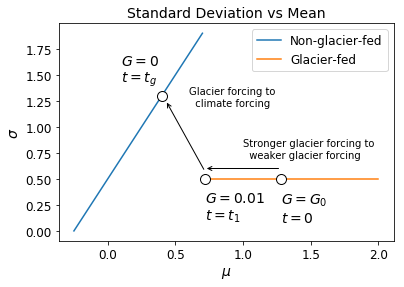

In [29]:
t_1 = t_g*(1 - 0.01/G_0) #time (years) when 1% glacierization threshold is reached (i.e. G(t_1) = 0.01)
N1 = int(t_1 / dt) #number of timesteps to 1% glacierization

mu_0 = 0.2*(11.6 + 1.74*np.log(G_0)) #initial mu (scaled from: Equation 4 and Supp. Fig. 2 in reference)
mu_g = 0.2*(11.6 + 1.74*np.log(0.01)) #mu at 1% glacierization
mu_f = 0.4 #final mu

sigma_0 = 0.5 #initial sigma
sigma_g = sigma_0 #sigma at 1% glacierization
sigma_f = 0.5 + 2.*mu_f #final sigma (estimated from relationship between sigma and mu)

mu_climate = np.linspace(-0.25,0.7,100) #climate driven mu (estimated from Figure a))
sigma_climate = 0.5 + 2.*mu_climate #climate driven sigma

mu_glaciers = np.linspace(mu_g,2,100) #glacier-driven mu
sigma_glaciers = 0.5 * np.ones_like(mu_glaciers) #glacier-driven sigma

#visualize
fig, ax = plt.subplots()

ax.plot(mu_climate, sigma_climate, label = 'Non-glacier-fed')
ax.plot(mu_glaciers, sigma_glaciers, label = 'Glacier-fed')

ax.scatter(mu_0, sigma_0, s = 100, edgecolor = 'k', zorder = 3, facecolor = 'w')
ax.text(x = mu_0+0., y = sigma_0 - 0.4, s = '$G=G_0$ \n$t=0$', fontsize = fs)

ax.scatter(mu_g, sigma_g, s = 100, edgecolor = 'k', zorder = 3, facecolor = 'w')
ax.text(x = mu_g+0., y = sigma_g - 0.4, s = '$G=0.01$ \n$t=t_1$', fontsize = fs)

ax.scatter(mu_f, sigma_f, s = 100, edgecolor = 'k', zorder = 3, facecolor = 'w')
ax.text(x = mu_f - 0.3, y = sigma_f + 0.1, s = '$G=0$ \n$t=t_g$', fontsize = fs)

ax.annotate("", xy = (mu_g, sigma_g+0.1), xytext = (mu_0, sigma_0+0.1), arrowprops = dict(arrowstyle="->"))
ax.annotate("", xy = (mu_f+0.03, sigma_f-0.05), xytext = (mu_g-0.0, sigma_g+0.075), arrowprops = dict(arrowstyle="->"))

ax.text(x = 1., y = 0.7, s = 'Stronger glacier forcing to \n  weaker glacier forcing', fontsize = fs-4)
ax.text(x = 0.6, y = 1.2, s = 'Glacier forcing to \n  climate forcing', fontsize = fs-4, rotation = 0)

ax.legend(fontsize = fs - 2)
ax.set_xlabel('$\mu$', fontsize = fs)
ax.set_ylabel('$\sigma$', fontsize = fs)
ax.set_title('Standard Deviation vs Mean', fontsize = fs)
#ax.set_ylim((0.5, 4.25))
ax.tick_params(labelsize = fs-2)

plt.show()

Between time $t=0$ and $t=t_1$, as the percentage glacierization decreases from $G(0) = G_0$ to $G(t_1)=0.01$, $\mu$ decreases according to Equation 4 and Supp. Fig. 2 in Anderson and Radic (2020):

$$
\mu = 0.2\times\bigg(11.58 + 1.74\times ln(G)\bigg)
$$

During this time, $\sigma$ stays approximately constant.  Then, between time $t=t_1$ and $t=t_g$, as the percentage glacierization decreases from $G(t_1) = 0.01$ to $G(t_g)=0$, two things happen:

- $\mu$ transitions from:
    - $\mu(G = 0.01)$ $\rightarrow$ $\mu\bigg(T_{year}, P_{JJA}, T_{JJA}, E_{JJA}, log_{10}\big(\frac{Q_{min}}{Q_{max}}\big)\bigg)$ 
    - i.e. $\mu$ transitions from being predictable by glacierization to being predictable by climate and local characteristics
    
    
- $\sigma$ transitions from: 
    - $\sigma = 0.5$ $\rightarrow$ $\sigma\bigg(P_{JJA}, E_{JJA}, h, log_{10}\big(\frac{Q_{min}}{Q_{max}}\big)\bigg)$ 
    - i.e. $\sigma$ transitions from being roughly constant irrespective of glacierization to being predictable by climate and local characteristics
    
Since there is limited data detailing the form of this transition, let's assume that it is linear with time for both $\mu$ and $\sigma$.

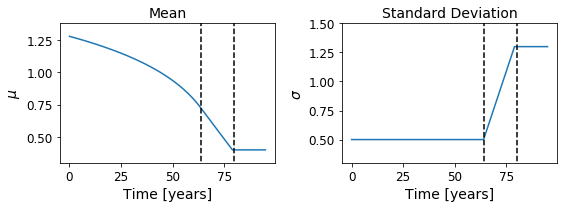

In [30]:
#define mu and sigma arrays through whole time period
mu = np.zeros_like(t) #initialize mu array
mu[:N1] = 0.2*(11.6 + 1.74*np.log(G[:N1])) #mu follows mu = mu(G) up until the 1% glacierization time
mu[N1:Ng] = np.linspace(mu_g, mu_f, Ng-N1) #then, between 1% glacierization and 0% glacierization, linear between mu_g and PC1_f
mu[Ng:] = mu_f #after glaciers lost, mu stays constant

sigma = np.zeros_like(t) #initialize sigma array
sigma[:N1] = np.linspace(sigma_0, sigma_g, N1) #sigma is constant before 1% glacierization time
sigma[N1:Ng] = np.linspace(sigma_g, sigma_f, Ng-N1) #linear transition to sigma_f
sigma[Ng:] = sigma_f #sigma remains constant after glaciers lost

#define dashed vertical lines to show t_1 and t_g on figures
dashx_g = t_g * np.ones(10)
dashy_g = np.linspace(-10,10,10)
dashx_1 = (t_1) * np.ones(10)
dashy_1 = np.linspace(-10,10,10)

#visualize linear transition
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8,3))

axes[0].plot(t,mu)
axes[0].plot(dashx_g, dashy_g, 'k--')
axes[0].plot(dashx_1, dashy_1, 'k--')
axes[0].set_xlabel('Time [years]', fontsize = fs)
axes[0].set_ylabel('$\mu$', fontsize = fs)
axes[0].set_title('Mean', fontsize = fs)
axes[0].set_ylim((np.min(mu) - 0.1, np.max(mu)+0.1))
axes[0].tick_params(labelsize = fs-2)

axes[1].plot(t, sigma)
axes[1].plot(dashx_g, dashy_g, 'k--')
axes[1].plot(dashx_1, dashy_1, 'k--')
axes[1].set_xlabel('Time [years]', fontsize = fs)
axes[1].set_ylabel('$\sigma$', fontsize = fs)
axes[1].set_title('Standard Deviation', fontsize = fs)
axes[1].set_ylim((np.min(sigma) - 0.2, np.max(sigma)+0.2))
axes[1].tick_params(labelsize = fs-2)

fig.tight_layout()

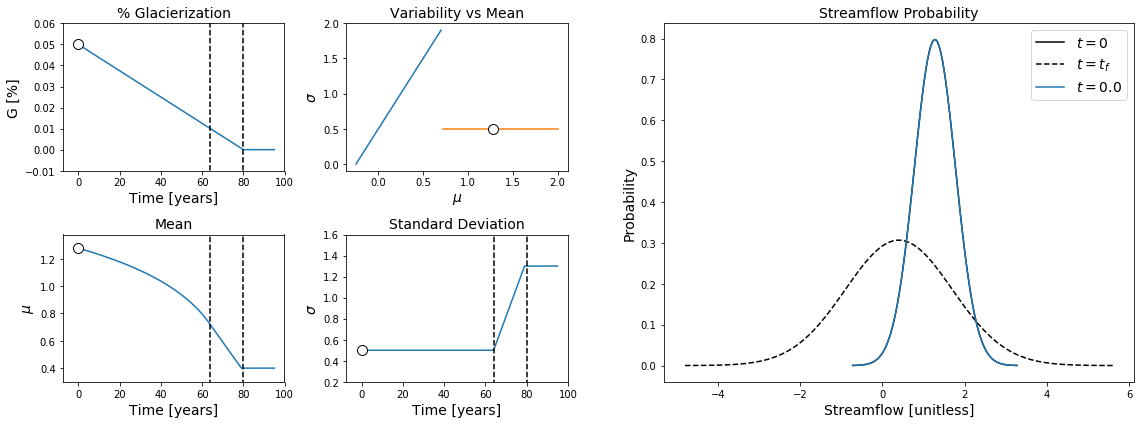

In [31]:
#visualize time progression with a Widget!

slider_time = ipywidgets.FloatSlider(value = 0, min=0, max = t_f, description = 'Time', continuous_update=False)

@ipywidgets.interact(tt = slider_time)#, eigvecs = eigvecs, PCs = PCs)

def plot_things(tt):

    if tt < t_g:
        GG = G_0 * (1 - tt/t_g)
    else:
        GG = 0

    if GG >= 0.01: #if glacier-forcing
        PP =  0.2*(11.6 + 1.74*np.log(GG))
        ss = sigma_0
    elif (GG<0.1) & (GG>0): #if transitioning from glacier-to-climate

        mu_1 = 0.2*(11.6 + 1.74*np.log(0.01))
        m = (mu_f - mu_g)/(t_g - t_1)
        b = mu_g - m*t_1
        PP = m*tt+b

        m = (sigma_f - sigma_g)/(t_g - t_1)
        b = sigma_g - m*t_1
        ss = m*tt+b

    else:
        PP = mu_f
        ss = sigma_f

    dashx_g = t_g * np.ones(10)
    dashy_g = np.linspace(-10,10,10)
    dashx_1 = t_1 * np.ones(10)
    dashy_1 = np.linspace(-10,10,10)

    fig = plt.subplots(figsize = (16,6))

    ax = plt.subplot(2, 4, 1)
    ax.plot(t, G)
    ax.plot(dashx_g, dashy_g, 'k--')
    ax.plot(dashx_1, dashy_1, 'k--')
    ax.scatter(tt, GG, s = 100, linewidth = 1, edgecolor = 'k', facecolor = 'w', zorder = 3)
    ax.set_xlabel('Time [years]', fontsize = fs)
    ax.set_ylabel('G [%]', fontsize = fs)
    ax.set_title('% Glacierization', fontsize = fs)
    ax.set_ylim((np.min(G) - 0.01, np.max(G)+0.01))

    ax = plt.subplot(2, 4, 2)
    ax.plot(mu_climate, sigma_climate)
    ax.plot(mu_glaciers, sigma_glaciers)
    ax.scatter(PP, ss, s = 100, linewidth = 1, edgecolor = 'k', facecolor = 'w', zorder = 3)
    ax.set_xlabel('$\mu$', fontsize = fs)
    ax.set_ylabel('$\sigma$', fontsize = fs)
    ax.set_title('Variability vs Mean', fontsize = fs)

    ax = plt.subplot(2, 4, 5)
    ax.plot(t,mu)
    ax.plot(dashx_g, dashy_g, 'k--')
    ax.plot(dashx_1, dashy_1, 'k--')
    ax.scatter(tt, PP, s = 100, linewidth = 1, edgecolor = 'k', facecolor = 'w', zorder = 3)
    ax.set_xlabel('Time [years]', fontsize = fs)
    ax.set_ylabel('$\mu$', fontsize = fs)
    ax.set_title('Mean', fontsize = fs)
    ax.set_ylim((np.min(mu) - 0.1, np.max(mu)+0.1))

    ax = plt.subplot(2, 4, 6)
    ax.plot(t, sigma)
    ax.plot(dashx_g, dashy_g, 'k--')
    ax.plot(dashx_1, dashy_1, 'k--')
    ax.scatter(tt, ss, s = 100, linewidth = 1, edgecolor = 'k', facecolor = 'w', zorder = 3)
    ax.set_xlabel('Time [years]', fontsize = fs)
    ax.set_ylabel('$\sigma$', fontsize = fs)
    ax.set_title('Standard Deviation', fontsize = fs)
    ax.set_ylim((np.min(sigma) - 0.3, np.max(sigma)+0.3))

    ax = plt.subplot(1, 2, 2)
    gauss_0, x_0 = make_gaussian(mu = mu_0, sigma = sigma_0)
    gauss_f, x_f = make_gaussian(mu = mu_f, sigma = sigma_f)
    gauss, x = make_gaussian(mu = PP, sigma = ss)
    ax.plot(x_0,gauss_0, 'k', label = '$t = 0$')
    ax.plot(x_f,gauss_f, 'k--', label = '$t = t_f$')
    ax.plot(x,gauss, label = '$t = $' + str(tt))
    ax.set_xlabel('Streamflow [unitless]', fontsize = fs)
    ax.set_ylabel('Probability', fontsize = fs)
    ax.set_title('Streamflow Probability', fontsize = fs)
    ax.legend(fontsize = fs)

    plt.tight_layout()

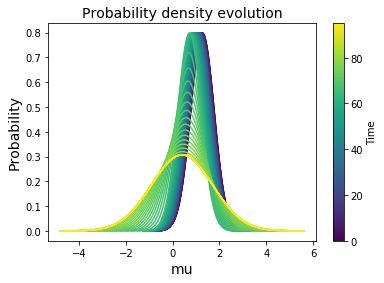

In [32]:
#visualize all streamflow probability densities in one figure

gausses = [] #empty list for all probabilities
xs = [] #empty list for all x-coordinates of probabilities
for t_step, mu_step, sigma_step in zip(t, mu, sigma):
    gauss, x = make_gaussian(mu = mu_step, sigma = sigma_step)
    gausses.append(gauss)
    xs.append(x)
    
gausses = np.asarray(gausses)
xs = np.asarray(xs)

#define colourmap for time
cmap = 'viridis'
norm = colors.Normalize(vmin=min(t),vmax=max(t))
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])

cs = cm.get_cmap(cmap, Nf-1) #colours

fig, ax = plt.subplots()
for ii, tt in enumerate(t):
    ax.plot(xs[ii],gausses[ii], color = cs(ii))
ax.set_xlabel('mu', fontsize = fs)
ax.set_ylabel('Probability', fontsize = fs)
ax.set_title('Probability density evolution', fontsize = fs)
cb = fig.colorbar(mappable, ax = ax)
cb.set_label('Time')

___

### Questions we can ask

Which communities in Alberta source their municipal water supply from a glacier-fed river at a location where that glacier-fed river will substantially change?

To answer this, we can:

1) Identify where communities get their water from  
2) For those which get water from glacier-fed rivers ($G>0.01$), model $\mu$ and $\sigma$ for the glacier-fed and non-glacier-fed cases  
3) Compare streamflow distributions for both cases  

We find that four locations are most vulnerable: the town of Hinton, the hamlet of Lake Louise, the Bighorn Dam, and the town of Rocky Mountain House (downstream of the Bighorn Dam).  The Bighorn Dam is the largest reservoir in Alberta, and $>1$ million people source water downstream from this dam.

<img src='streamflow_distributions.png' width=350 >

In this figure, the solid lines show modelled historical streamflow and dashed lines show estimated future streamflow without glaciers.

**Other questions we can ask**:

- Play around with $(\mu, \sigma)_{initial}$ and $(\mu, \sigma)_{final}$.  What does the transition look like under different initial and final conditions?
- Consider a community which sources water from a glacier-fed river: what would make one transition scenario worse/better than another?  What do 'bad' transitions look like in terms of initial and final conditions?  Where, geographically, might this happen?
- What percent of glacier area can we afford to lose before the year-to-year variability begins to substantially increase?
- Under what conditions might streamflow rise (however briefly) under a loss of glaciers?  What happens if the variability increases substantially, but the mean only decreases slightly?  What pair of $(\mu, \sigma)_{initial}$ and $(\mu, \sigma)_{final}$ could lead to this?  Check out the map of Alberta where this type of $(\mu, \sigma)_{final}$ exists.  What climate is this?  Are there glaciated places on Earth with this type of climate?
- Based on these probabilities, generate a set of mean August streamflow timeseries.  What interesting features do you notice?

### Reference
Here is a [link to the paper](https://rdcu.be/b53pJ) which is used as a base for the discussion in the notebook.
  
Anderson, S., Radić, V. Identification of local water resource vulnerability to rapid deglaciation in Alberta.  *Nat. Clim. Chang.* **10**, 933 - 938 (2020).